In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

my_dpi = 300 


In [2]:
df_hour = pd.read_csv('./hour.csv')
df_day = pd.read_csv('./day.csv')

In [3]:
df_hour.shape, df_day.shape

((17379, 17), (731, 16))

In [4]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## EDA bike-sharing 
-----------------------

##### 'Hours' of day  is very important feature to predict the count 
#### It shows some cyclical patterns 

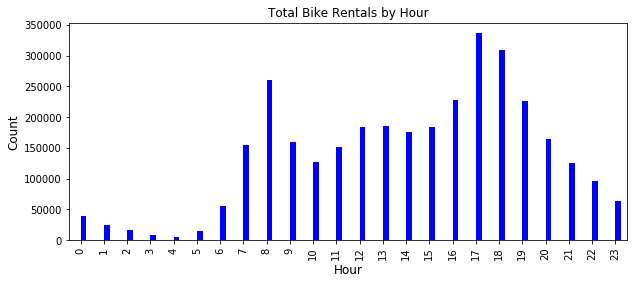

In [6]:

ax = df_hour[['hr','cnt']].groupby(['hr']).sum().reset_index().plot(kind='bar', figsize=(10, 4), 
                                       legend = False, title ="Total Bike Rentals by Hour", 
                                       color='blue', fontsize=10)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


#### 'day of week' feature does not show significant differences 
#### 0 - sun, 1 - mon, ...... 6 - sat


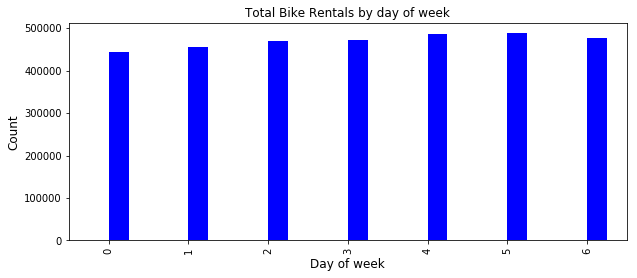

In [7]:

ax = df_hour[['weekday','cnt']].groupby(['weekday']).sum().reset_index().plot(kind='bar', figsize=(10, 4),
                                       legend = False, title ="Total Bike Rentals by day of week", 
                                       color='blue', fontsize=10)
ax.set_xlabel("Day of week", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


## Working day & Non comparison
-----------------------
#### Front row 0~23 : non-working , Later row 24~27 : working day
#### Total cnt is little different but I guess the non-working days are less than working days
#### so I need to normalize the cnt by per day 

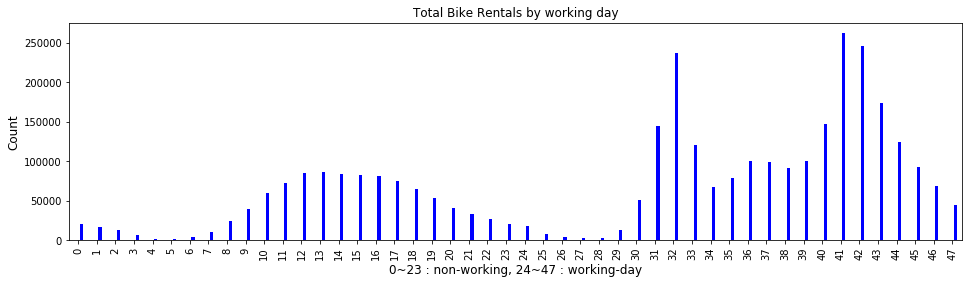

In [8]:

ax = df_hour[['workingday','hr','cnt']].groupby(['workingday','hr']).sum().reset_index().plot(kind='bar', figsize=(16, 4),
                                       legend = False, title ="Total Bike Rentals by working day", 
                                       color='blue', fontsize=10)
ax.set_xlabel("0~23 : non-working, 24~47 : working-day", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


### Normalized Count per day chart
--------------------
- That show the definite different patterns non-working & working day 
- The peak rental time in non-working day is mid-day ( 13~15 o'clock )
- However the peak rental time in working day indicate commute hour ( AM 8, 18~19 o'clock ) 


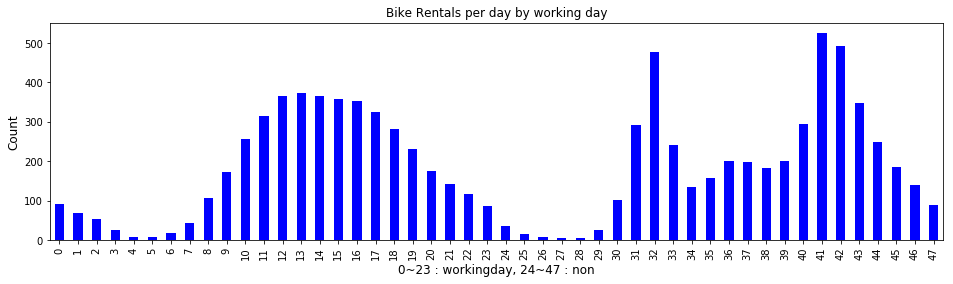

In [9]:
df_workday = df_hour[['workingday','hr','cnt']].groupby(['workingday','hr']).sum().reset_index()
df_workday_cnt = df_hour[['workingday','hr','cnt']].groupby(['workingday','hr']).count().reset_index()
df_workday['ocr'] = df_workday_cnt['cnt']
## Normalize per Day 
df_workday['ratio'] = df_workday['cnt'] / df_workday['ocr']
df_workday = df_workday.drop(['ocr'], axis=1)
ax = df_workday['ratio'].plot(kind='bar', figsize=(16, 4),
                                       legend = False, title ="Bike Rentals per day by working day", 
                                       color='blue', fontsize=10)
ax.set_xlabel("0~23 : workingday, 24~47 : non", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

#### final check 
- day of week patern is similar to working / non 
- first (sun) and last ( sat ) is similar patter to non-working day 

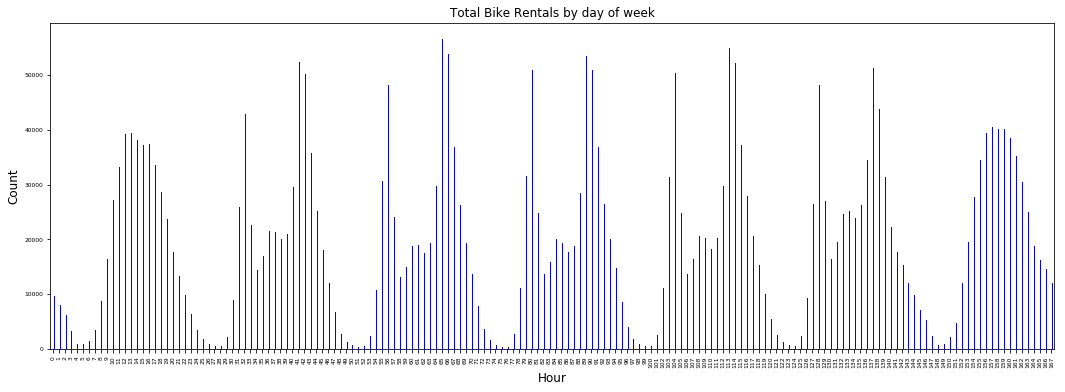

In [10]:
ax = df_hour[['weekday','hr','cnt']].groupby(['weekday','hr']).sum().reset_index().plot(kind='bar', figsize=(18, 6),
                                       legend = False, title ="Total Bike Rentals by day of week", 
                                       color='blue', fontsize=6)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

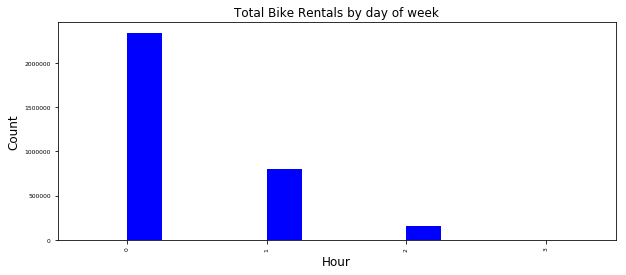

In [11]:

ax = df_hour[['weathersit','cnt']].groupby(['weathersit']).sum().reset_index().plot(kind='bar', figsize=(10, 4),
                                       legend = False, title ="Total Bike Rentals by day of week", 
                                       color='blue', fontsize=6)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

